In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

n_epochs = 1000
batch_size = 10
LR =1e-4
Lv1_latent_dim = 64

alpha = 0

In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))


data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
print(data.shape)
#print(data)
data_save[0,0:num_node,:]=data.values[0:num_node,:]

"""
del(data)
data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
print(data.shape)
data_save[1,0:num_node,:]=data.values[0:num_node,:]
"""
"""
del(data)
data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]

del(data)
data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]
del(data)

"""


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


In [11]:
# validate
data_save.shape

(1, 14300, 8000)

In [12]:
data_save[0,:,0]

array([-6.67990629e-02, -1.12730000e-04, -5.53449498e-02, ...,
        9.77615776e-05,  1.00696836e-04,  1.32496039e-04])

In [13]:
x_axis = np.linspace(0,num_node,num_node)
x_axis2 = np.linspace(0, num_time, num_time)

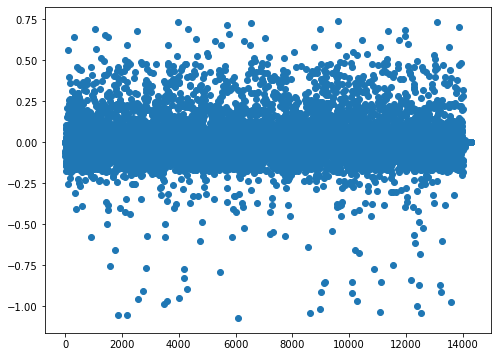

In [14]:
plt.scatter(x_axis, data[0,:,0])

In [15]:
data

array([[[-6.67990629e-02, -6.68890629e-02, -6.69890629e-02, ...,
          8.10709371e-02,  8.42309371e-02,  8.71309371e-02],
        [-1.12730000e-04, -1.12730000e-04, -1.12730000e-04, ...,
          1.57270000e-04,  1.57270000e-04,  1.57270000e-04],
        [-5.53449498e-02, -5.74049498e-02, -5.91949498e-02, ...,
          1.15445050e-01,  9.46250502e-02,  7.57050502e-02],
        ...,
        [ 9.77615776e-05,  1.01973578e-04,  1.05853578e-04, ...,
         -2.23790224e-05, -3.41959224e-05, -4.55196224e-05],
        [ 1.00696836e-04,  1.05035836e-04,  1.09031836e-04, ...,
         -2.30509640e-05, -3.52225640e-05, -4.68861640e-05],
        [ 1.32496039e-04,  1.38205039e-04,  1.43464039e-04, ...,
         -3.03303613e-05, -4.63456613e-05, -6.16927613e-05]]])

## FOM data type : FOM_data = np.array[param, time, node, var]

In [16]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data.shape

(10, 800, 14300, 1)

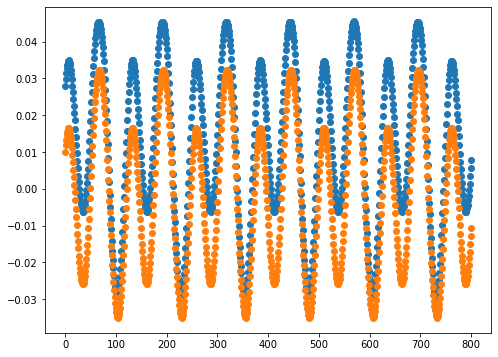

In [17]:
plt.scatter(x_axis2, FOM_data[5,:,0,0])
plt.scatter(x_axis2, FOM_data[4,:,0,0])

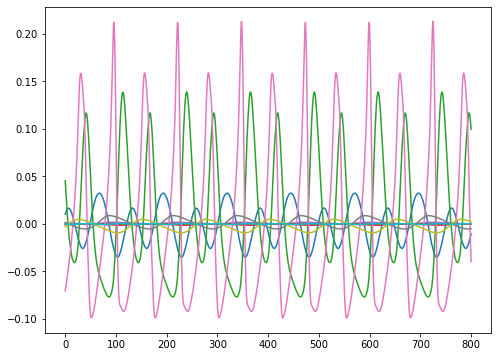

In [18]:
for i in range(10):
    plt.plot(x_axis2, FOM_data[4,:,i,0])

In [19]:
print(np.max(FOM_data[8,:,0,0]))
print(np.min(FOM_data[8,:,0,0]))

0.0791909371249988
-0.0096490628750012


In [20]:
x_axis

array([0.00000000e+00, 1.00006993e+00, 2.00013987e+00, ...,
       1.42979999e+04, 1.42989999e+04, 1.43000000e+04])

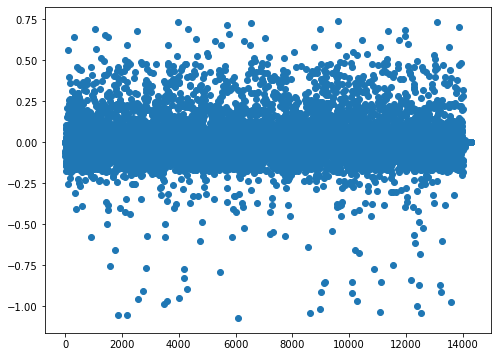

In [21]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [22]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0667990628750013
-0.0514190628750013
-0.0668890628750014
-0.0553449497500003


In [23]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [24]:
print(maximum)
print(minimum)
print(mean)
print(AT)

2.025240682
-3.0420853545825
1.0010634745392302e-15
5.0673260365825


In [25]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT

In [26]:
print(np.max(FOM_data))
print(np.min(FOM_data))

0.3996665435338476
-0.6003334564661524


In [27]:
FOM_data.shape

(10, 800, 14300, 1)

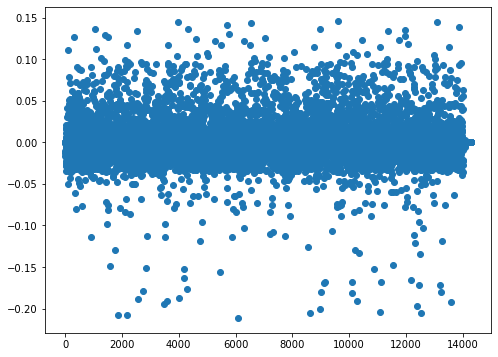

In [28]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

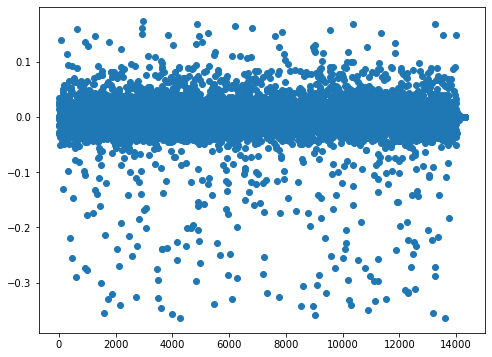

In [29]:
plt.scatter(x_axis, FOM_data[2,0,:,0])

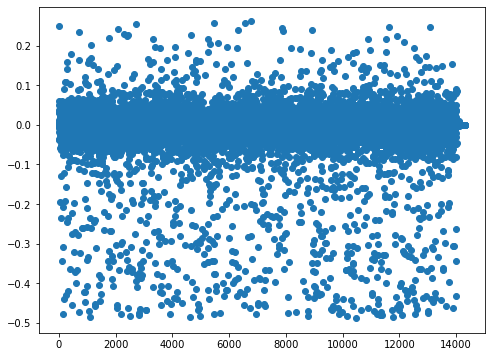

In [30]:
plt.scatter(x_axis, FOM_data[9,0,:,0])

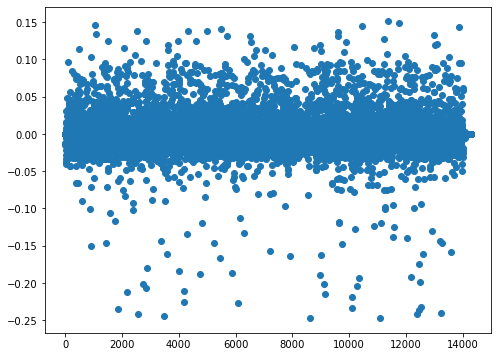

In [31]:
plt.scatter(x_axis, FOM_data[0,4,:,0])

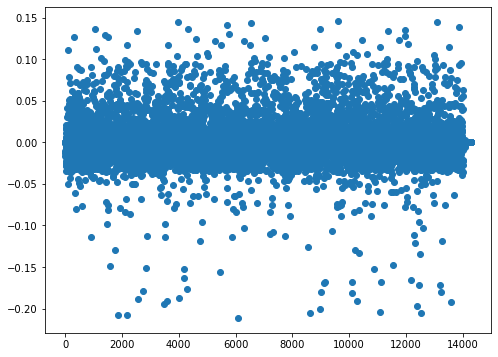

In [32]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

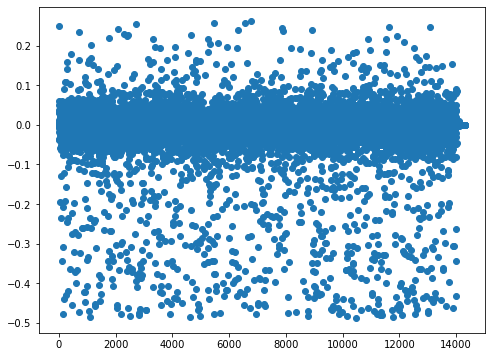

In [33]:
plt.scatter(x_axis, FOM_data[9,0,:,0])

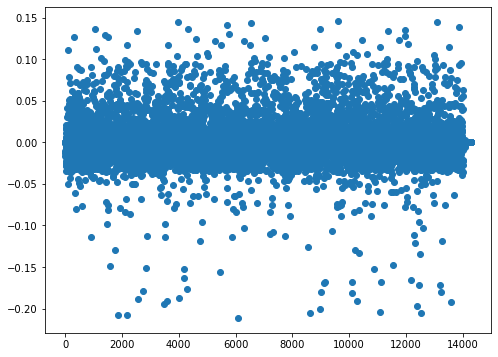

In [34]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

# Level 1, SVAE (spatial VAE)

In [35]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 14300, 1)

In [36]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [37]:
Lv1_input_shape = Lv1_input.shape[1:]

In [38]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 14300, 1)
(14300, 1)


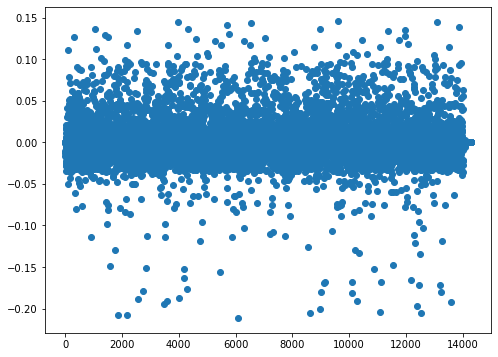

In [39]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Acquire latent vectors

In [40]:
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

epoch = n_epochs
filename1='test_constrained_ae/encoder_%dbatchnorm.h5' % (epoch)
filename2='test_constrained_ae/decoder_%dbatchnorm.h5' % (epoch)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()
temp_lv1 = np.zeros([1,Lv1_input.shape[1],Lv1_input.shape[2]])
Lv1_latent = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    for j in range(num_time):
        k = i*num_time+j
        print(k)
        temp_lv1[0,:,:] = Lv1_input[k,:,:]
        
        temp3= Encoder(temp_lv1, training=False) # Encoder output shape : mu, sigma, latent_vector = Encoder(x_train, training=False)
        
        Lv1_latent[i,j,:] = np.asarray(temp3)[0,:]
        
        # Lv1_latent [param, time, latent] -> reduced spatial dimension to latent dimension.

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14300, 32)         192       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14300, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14300, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14300, 64)         10304     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14300, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14300, 64)         0   

1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218


2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865


4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545


6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201


7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860


In [41]:
print(Lv1_latent.shape)

(10, 800, 64)


In [42]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

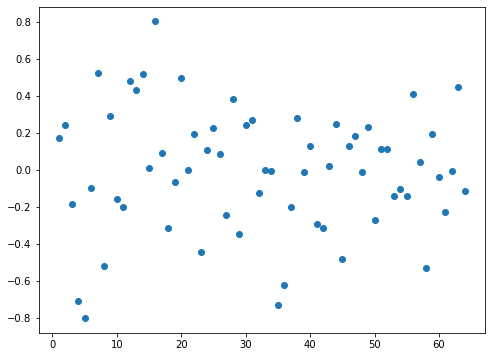

In [43]:
plt.scatter(x_axis1, Lv1_latent[0,2,:])

# Accuracy of VAE

In [44]:
Lv1_latent.shape

(10, 800, 64)

In [45]:
to_plot = np.zeros([num_param, num_time, num_node,num_var])
#param_to_eval = 4

for j in range(num_param):
    for i in range(num_time):
        #print(j)
        temp4 = Lv1_latent[j,i,:]

        temp4 = np.reshape(temp4, [-1, Lv1_latent_dim])
        EX = Decoder(temp4) # EX : decoded temp4
        to_plot[j,i,:,:] = EX[0,:,:]

In [46]:
print(EX.shape)
print(to_plot.shape)
print(Lv1_input.shape)

(1, 14300, 1)
(10, 800, 14300, 1)
(8000, 14300, 1)


In [47]:
x_axis3 = np.linspace(1,num_time,num_time)

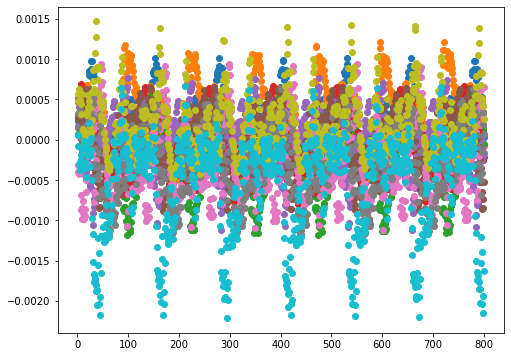

In [48]:
for i in range(num_param):
    plt.scatter(x_axis3, to_plot[i, :,0,0]-FOM_data[i,:,0,0])

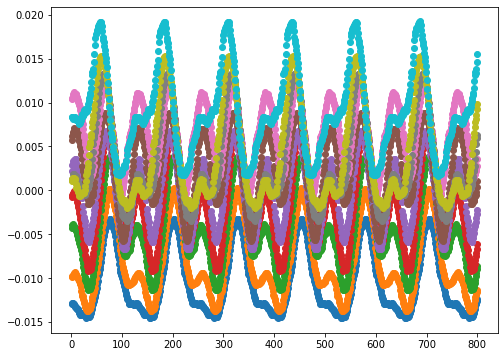

In [49]:
for i in range(num_param):
    plt.scatter(x_axis3, to_plot[i, :,0,0])

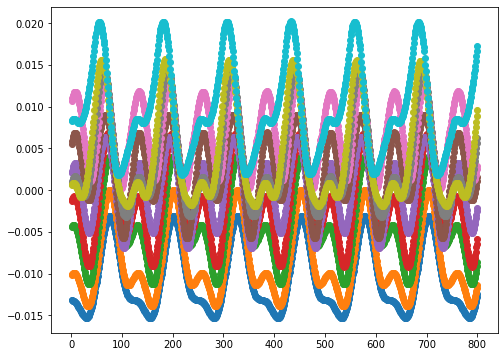

In [50]:
for i in range(num_param):
    plt.scatter(x_axis3, FOM_data[i,:,0,0])

In [51]:
Lv1_input.shape

(8000, 14300, 1)

# Reconstruction : time+parameter at a certain node point

In [52]:
Lv1_input.shape

(8000, 14300, 1)

In [53]:
hola = np.zeros([1,num_node,1])

hola[0,:,:] = Lv1_input[0,:,:]
print(hola.shape)

(1, 14300, 1)


In [54]:

hola2 = Encoder(hola)
hola3 = Decoder(hola2)

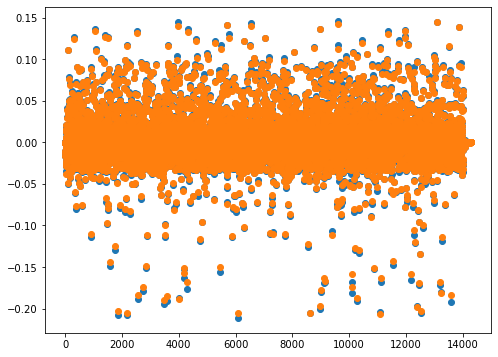

In [55]:
plt.scatter(x_axis, hola[0,:,0])
plt.scatter(x_axis, hola3[0,:,0])

(1, 14300, 1)


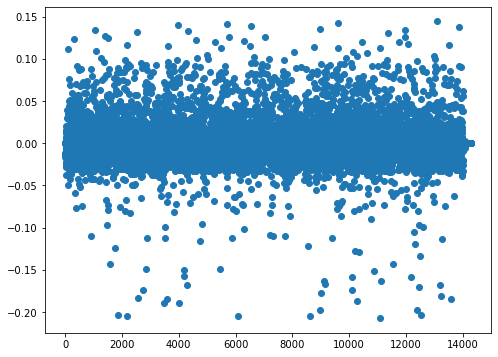

In [56]:
print(hola3.shape)
plt.scatter(x_axis, hola3[0,:,0])

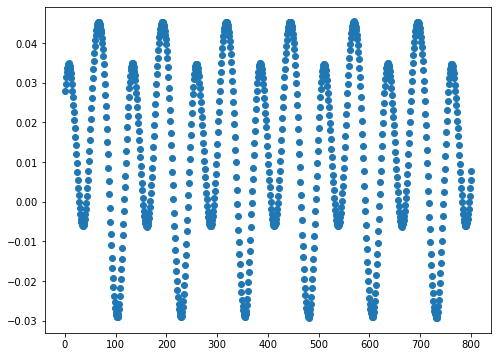

In [57]:
# FOM_data = (num_param, num_time, num_node, num_var)

x_axis1 = np.linspace(1,num_time,num_time)
plt.scatter(x_axis1, FOM_data[5,:,0,0]*AT+mean)

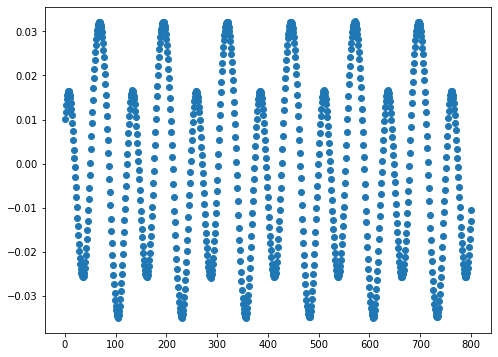

In [58]:
# FOM_data = (num_param, num_time, num_node, num_var)

x_axis1 = np.linspace(1,num_time,num_time)
plt.scatter(x_axis1, FOM_data[4,:,0,0]*AT+mean)

In [59]:
np.min(FOM_data[4,:,0,0]*AT+mean)

-0.0350690628750012

# Output latent vectors to file,

In [60]:
# Save latent vectors for each parameter...

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d_batchnorm' %(i+1)
    np.savetxt(filename3, Lv1_latent[i,:,:], fmt = '%f')

In [61]:
Lv1_latent.shape

(10, 800, 64)

In [62]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

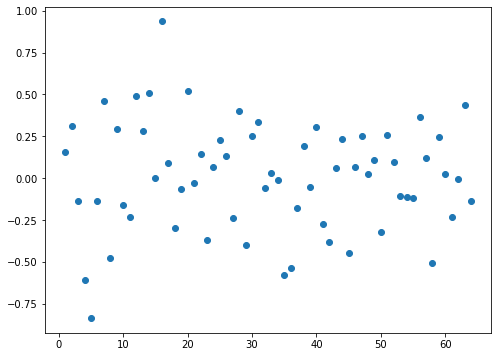

In [63]:
plt.scatter(x_axis1, Lv1_latent[0,0,:])

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [64]:
del Encoder
del Decoder